In [3]:
import os
import numpy as np

import torch, torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
#from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader

from pathlib import Path

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib import colors

import sys

from tqdm import tqdm

plt.rcParams["image.cmap"] = "jet"

In [4]:
#save model pth
save=True

# Setting path
path = Path("Y:/ptychosaxs")  # /net/micdata/data2/12IDC mounted windows drive
path = Path("/net/micdata/data2/12IDC/ptychosaxs/")
# Join paths
MODEL_SAVE_PATH = path / 'trained_model/' # Automatically adds the correct separator
if (not os.path.isdir(MODEL_SAVE_PATH)):
    os.mkdir(MODEL_SAVE_PATH)
print(MODEL_SAVE_PATH)

/net/micdata/data2/12IDC/ptychosaxs/trained_model


In [5]:
# Load preprocessed data
num=31#17
numDPs=10800#10000

# Load the data once instead of three times
data_path = os.path.abspath(os.path.join(os.getcwd(), f'../../data/processed/preprocessed_dir{num}_numDPs{numDPs}.npz'))
data = np.load(data_path)

# Extract the arrays
amp_conv_red = data['amp_conv_red']
amp_ideal_red = data['amp_ideal_red']
amp_probe_red = data['amp_probe_red']

In [6]:
# Set the number of patterns in test, train or validation set
NTEST = amp_conv_red.shape[0]//4
NTRAIN = amp_conv_red.shape[0]-NTEST
NVALID = NTEST//2 # NTRAIN//

print(NTRAIN,NTEST,NVALID)

8100 2700 1350


In [ ]:
EPOCHS = 1024
NGPUS = torch.cuda.device_count()
BATCH_SIZE = NGPUS*16
LR = NGPUS * 1e-3
print("GPUs:", NGPUS, "Batch size:", BATCH_SIZE, "Learning rate:", LR)

no_probe=True
H,W=amp_ideal_red[0].shape[0],amp_ideal_red[0].shape[1]
print(H,W)

GPUs: 2 Batch size: 32 Learning rate: 0.002
256 256


In [8]:
#separate data and convert to tensors and shuffle
no_probe=True

tst_start = amp_conv_red.shape[0]-NTEST

X_train = amp_conv_red[:NTRAIN].reshape(-1,H,W)[:,np.newaxis,:,:]
X_test = amp_conv_red[tst_start:].reshape(-1,H,W)[:,np.newaxis,:,:]

Xp_train = amp_probe_red[:NTRAIN].reshape(-1,H,W)[:,np.newaxis,:,:]
Xp_test = amp_probe_red[tst_start:].reshape(-1,H,W)[:,np.newaxis,:,:]

Y_I_train = amp_ideal_red[:NTRAIN].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_I_test = amp_ideal_red[tst_start:].reshape(-1,H,W)[:,np.newaxis,:,:]

ntrain=X_train.shape[0]
ntest=X_test.shape[0]

X_train, Xp_train, Y_I_train = shuffle(X_train, Xp_train, Y_I_train, random_state=0)

#Training data
X_train_tensor = torch.Tensor(X_train)
Xp_train_tensor = torch.Tensor(Xp_train) 
Y_I_train_tensor = torch.Tensor(Y_I_train) 

#Test data
X_test_tensor = torch.Tensor(X_test)
Xp_test_tensor = torch.Tensor(Xp_test) 
Y_I_test_tensor = torch.Tensor(Y_I_test) 

print(X_train_tensor.shape,Xp_train_tensor.shape, Y_I_train_tensor.shape)


if no_probe:
    train_data = TensorDataset(X_train_tensor,Y_I_train_tensor)
    test_data = TensorDataset(X_test_tensor,Xp_test_tensor)
else:
    train_data = TensorDataset(X_train_tensor,Xp_train_tensor,Y_I_train_tensor)
    test_data = TensorDataset(X_test_tensor,Xp_test_tensor)


N_TRAIN = X_train_tensor.shape[0]

train_data2, valid_data = torch.utils.data.random_split(train_data,[N_TRAIN-NVALID,NVALID])
print(len(train_data2),len(train_data2[0]),len(valid_data),len(test_data))


#download and load training data
trainloader = DataLoader(train_data2, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

validloader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

#same for test
#download and load training data
testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

torch.Size([8100, 1, 256, 256]) torch.Size([8100, 1, 256, 256]) torch.Size([8100, 1, 256, 256])
6750 2 1350 2700


In [42]:
import sys
import os
import importlib

# Add the models directory to the path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../src/models/')))

# First, try to import the module
try:
    import encoder1_no_Unet
    # Force reload the module
    importlib.reload(encoder1_no_Unet)
    # Now import the class from the freshly reloaded module
    from encoder1_no_Unet import recon_model
    print("Successfully imported recon_model")
except Exception as e:
    print(f"Import error: {e}")
    
# # First, try to import the module
# try:
#     import encoder1
#     importlib.reload(encoder1)
#     # Now import the class from the freshly reloaded module
#     from encoder1 import recon_model
#     print("Successfully imported recon_model")
# except Exception as e:
#     print(f"Import error: {e}")


model = recon_model()
load_prev_model=False

Successfully imported recon_model


In [43]:
if no_probe:
    for ampsI,ampsO in trainloader:
        print("batch size:", ampsI.shape)
        amp = model(ampsI)#,ampsP)
        print(amp.shape)
        print(amp.dtype)
        break
else:
    for ampsI,ampsP,ampsO in trainloader:
        print("batch size:", ampsI.shape)
        amp = model(ampsI,ampsP)
        print(amp.shape)
        print(amp.dtype)
        break    

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    #model = nn.parallel.DistributedDataParallel(model) #Default all devices
    model = nn.DataParallel(model)

model = model.to(device)
print(model)

batch size: torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])
torch.float32
Let's use 2 GPUs!
DataParallel(
  (module): recon_model(
    (encoder1): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (encoder2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (encoder3): Sequential(
      (0): Co

In [44]:
#Optimizer details
iterations_per_epoch = np.floor((NTRAIN-NVALID)/BATCH_SIZE)+1 #Final batch will be less than batch size
step_size = 6*iterations_per_epoch #Paper recommends 2-10 (6) number of iterations, step_size is half cycle
print(iterations_per_epoch)
print("LR step size is:", step_size, "which is every %d epochs" %(step_size/iterations_per_epoch))



criterion = nn.L1Loss()
    

optimizer = torch.optim.Adam(model.parameters(), lr = LR, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=LR/10, max_lr=LR, step_size_up=step_size,
                                              cycle_momentum=False, mode='triangular2')
                                              
                                              
                                              #Function to update saved model if validation loss is minimum
def update_saved_model(model, path):
    if not os.path.isdir(path):
        os.mkdir(path)
    for f in os.listdir(path):
        os.remove(os.path.join(path, f))
    if (NGPUS>1):    
        torch.save(model.module.state_dict(),path / 'best_model_ZCB_9.pth') #Have to save the underlying model else will always need 4 GPUs
    else:
        torch.save(model,path / 'best_model_ZCB_9.pth')

def train(trainloader,metrics):
    tot_loss = 0.0
    loss_amp = 0.0
    
    for i, (ft_images,amps) in tqdm(enumerate(trainloader)):
        ft_images = ft_images.to(device) #Move everything to device
        amps = amps.to(device)
        pred_amps = model(ft_images) #Forward pass
        
        #Compute losses
        loss_a = criterion(pred_amps,amps) #Monitor amplitude loss
        loss = loss_a #Use equiweighted amps and phase

        #Zero current grads and do backprop
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()

        tot_loss += loss.detach().item()
        loss_amp += loss_a.detach().item()

        #Update the LR according to the schedule -- CyclicLR updates each batch
        scheduler.step() 
        metrics['lrs'].append(scheduler.get_last_lr())
        
        
    #Divide cumulative loss by number of batches-- sli inaccurate because last batch is different size
    metrics['losses'].append([tot_loss/i,loss_amp/i]) 

def validate(validloader,metrics):
    tot_val_loss = 0.0
    val_loss_amp = 0.0
    for j, (ft_images,amps) in enumerate(validloader):
        ft_images = ft_images.to(device)
        amps = amps.to(device)
        pred_amps = model(ft_images) #Forward pass

        val_loss_a = criterion(pred_amps,amps)
        val_loss = val_loss_a
    
        tot_val_loss += val_loss.detach().item()
        val_loss_amp += val_loss_a.detach().item()
    metrics['val_losses'].append([tot_val_loss/j,val_loss_amp/j])
  
  #Update saved model if val loss is lower
    if(tot_val_loss/j<metrics['best_val_loss']):
        print("Saving improved model after Val Loss improved from %.5f to %.5f" %(metrics['best_val_loss'],tot_val_loss/j))
        metrics['best_val_loss'] = tot_val_loss/j
        update_saved_model(model, MODEL_SAVE_PATH)



211.0
LR step size is: 1266.0 which is every 6 epochs


In [55]:
metrics = {'losses':[],'val_losses':[], 'lrs':[], 'best_val_loss' : np.inf}
for epoch in range (EPOCHS):
    
  #Set model to train mode
  model.train() 
  #Training loop
  train(trainloader,metrics)
    
  #Switch model to eval mode
  model.eval()
    
  #Validation loop
  validate(validloader,metrics)
  print('Epoch: %d | Total  | Train Loss: %.5f | Val Loss: %.5f' %(epoch, metrics['losses'][-1][0], metrics['val_losses'][-1][0]))
  print('Epoch: %d | Amp | Train Loss: %.5f | Val Loss: %.5f' %(epoch, metrics['losses'][-1][1], metrics['val_losses'][-1][1]))
  print('Epoch: %d | Ending LR: %.6f ' %(epoch, metrics['lrs'][-1][0])) 

211it [00:19, 10.91it/s]


Saving improved model after Val Loss improved from inf to 0.02089
Epoch: 0 | Total  | Train Loss: 0.02015 | Val Loss: 0.02089
Epoch: 0 | Amp | Train Loss: 0.02015 | Val Loss: 0.02089
Epoch: 0 | Ending LR: 0.000200 


211it [00:19, 10.94it/s]


Epoch: 1 | Total  | Train Loss: 0.02025 | Val Loss: 0.02098
Epoch: 1 | Amp | Train Loss: 0.02025 | Val Loss: 0.02098
Epoch: 1 | Ending LR: 0.000200 


211it [00:21, 10.05it/s]


Epoch: 2 | Total  | Train Loss: 0.02021 | Val Loss: 0.02126
Epoch: 2 | Amp | Train Loss: 0.02021 | Val Loss: 0.02126
Epoch: 2 | Ending LR: 0.000200 


211it [00:39,  5.31it/s]


Epoch: 3 | Total  | Train Loss: 0.02017 | Val Loss: 0.02091
Epoch: 3 | Amp | Train Loss: 0.02017 | Val Loss: 0.02091
Epoch: 3 | Ending LR: 0.000200 


211it [00:39,  5.39it/s]


Epoch: 4 | Total  | Train Loss: 0.02018 | Val Loss: 0.02118
Epoch: 4 | Amp | Train Loss: 0.02018 | Val Loss: 0.02118
Epoch: 4 | Ending LR: 0.000200 


211it [00:19, 10.89it/s]


Epoch: 5 | Total  | Train Loss: 0.02015 | Val Loss: 0.02137
Epoch: 5 | Amp | Train Loss: 0.02015 | Val Loss: 0.02137
Epoch: 5 | Ending LR: 0.000200 


211it [00:19, 10.82it/s]


Epoch: 6 | Total  | Train Loss: 0.02017 | Val Loss: 0.02146
Epoch: 6 | Amp | Train Loss: 0.02017 | Val Loss: 0.02146
Epoch: 6 | Ending LR: 0.000200 


211it [00:19, 10.88it/s]


Epoch: 7 | Total  | Train Loss: 0.02020 | Val Loss: 0.02128
Epoch: 7 | Amp | Train Loss: 0.02020 | Val Loss: 0.02128
Epoch: 7 | Ending LR: 0.000200 


211it [00:19, 10.90it/s]


Epoch: 8 | Total  | Train Loss: 0.02017 | Val Loss: 0.02115
Epoch: 8 | Amp | Train Loss: 0.02017 | Val Loss: 0.02115
Epoch: 8 | Ending LR: 0.000200 


211it [00:19, 10.89it/s]


Epoch: 9 | Total  | Train Loss: 0.02017 | Val Loss: 0.02098
Epoch: 9 | Amp | Train Loss: 0.02017 | Val Loss: 0.02098
Epoch: 9 | Ending LR: 0.000200 


211it [00:19, 10.89it/s]


Epoch: 10 | Total  | Train Loss: 0.02013 | Val Loss: 0.02134
Epoch: 10 | Amp | Train Loss: 0.02013 | Val Loss: 0.02134
Epoch: 10 | Ending LR: 0.000200 


211it [00:19, 10.76it/s]


Saving improved model after Val Loss improved from 0.02089 to 0.02083
Epoch: 11 | Total  | Train Loss: 0.02016 | Val Loss: 0.02083
Epoch: 11 | Amp | Train Loss: 0.02016 | Val Loss: 0.02083
Epoch: 11 | Ending LR: 0.000200 


211it [00:19, 10.89it/s]


Saving improved model after Val Loss improved from 0.02083 to 0.02075
Epoch: 12 | Total  | Train Loss: 0.02015 | Val Loss: 0.02075
Epoch: 12 | Amp | Train Loss: 0.02015 | Val Loss: 0.02075
Epoch: 12 | Ending LR: 0.000200 


211it [00:19, 10.90it/s]


Epoch: 13 | Total  | Train Loss: 0.02014 | Val Loss: 0.02101
Epoch: 13 | Amp | Train Loss: 0.02014 | Val Loss: 0.02101
Epoch: 13 | Ending LR: 0.000200 


211it [00:19, 10.88it/s]


Epoch: 14 | Total  | Train Loss: 0.02012 | Val Loss: 0.02087
Epoch: 14 | Amp | Train Loss: 0.02012 | Val Loss: 0.02087
Epoch: 14 | Ending LR: 0.000200 


211it [00:19, 10.89it/s]


Epoch: 15 | Total  | Train Loss: 0.02013 | Val Loss: 0.02075
Epoch: 15 | Amp | Train Loss: 0.02013 | Val Loss: 0.02075
Epoch: 15 | Ending LR: 0.000200 


211it [00:19, 10.89it/s]


Epoch: 16 | Total  | Train Loss: 0.02014 | Val Loss: 0.02115
Epoch: 16 | Amp | Train Loss: 0.02014 | Val Loss: 0.02115
Epoch: 16 | Ending LR: 0.000200 


211it [00:19, 10.90it/s]


Epoch: 17 | Total  | Train Loss: 0.02015 | Val Loss: 0.02117
Epoch: 17 | Amp | Train Loss: 0.02015 | Val Loss: 0.02117
Epoch: 17 | Ending LR: 0.000200 


211it [00:19, 10.89it/s]


Epoch: 18 | Total  | Train Loss: 0.02010 | Val Loss: 0.02078
Epoch: 18 | Amp | Train Loss: 0.02010 | Val Loss: 0.02078
Epoch: 18 | Ending LR: 0.000200 


211it [00:19, 10.88it/s]


Epoch: 19 | Total  | Train Loss: 0.02012 | Val Loss: 0.02116
Epoch: 19 | Amp | Train Loss: 0.02012 | Val Loss: 0.02116
Epoch: 19 | Ending LR: 0.000200 


211it [00:19, 10.86it/s]


Epoch: 20 | Total  | Train Loss: 0.02015 | Val Loss: 0.02121
Epoch: 20 | Amp | Train Loss: 0.02015 | Val Loss: 0.02121
Epoch: 20 | Ending LR: 0.000200 


211it [00:19, 10.90it/s]


Saving improved model after Val Loss improved from 0.02075 to 0.02068
Epoch: 21 | Total  | Train Loss: 0.02013 | Val Loss: 0.02068
Epoch: 21 | Amp | Train Loss: 0.02013 | Val Loss: 0.02068
Epoch: 21 | Ending LR: 0.000200 


211it [00:19, 10.84it/s]


Epoch: 22 | Total  | Train Loss: 0.02010 | Val Loss: 0.02110
Epoch: 22 | Amp | Train Loss: 0.02010 | Val Loss: 0.02110
Epoch: 22 | Ending LR: 0.000200 


211it [00:19, 10.88it/s]


Epoch: 23 | Total  | Train Loss: 0.02013 | Val Loss: 0.02089
Epoch: 23 | Amp | Train Loss: 0.02013 | Val Loss: 0.02089
Epoch: 23 | Ending LR: 0.000200 


211it [00:19, 10.79it/s]


Epoch: 24 | Total  | Train Loss: 0.02009 | Val Loss: 0.02099
Epoch: 24 | Amp | Train Loss: 0.02009 | Val Loss: 0.02099
Epoch: 24 | Ending LR: 0.000200 


211it [00:19, 10.88it/s]


Epoch: 25 | Total  | Train Loss: 0.02015 | Val Loss: 0.02108
Epoch: 25 | Amp | Train Loss: 0.02015 | Val Loss: 0.02108
Epoch: 25 | Ending LR: 0.000200 


211it [00:19, 10.88it/s]


Epoch: 26 | Total  | Train Loss: 0.02009 | Val Loss: 0.02104
Epoch: 26 | Amp | Train Loss: 0.02009 | Val Loss: 0.02104
Epoch: 26 | Ending LR: 0.000200 


211it [00:19, 10.87it/s]


Epoch: 27 | Total  | Train Loss: 0.02010 | Val Loss: 0.02116
Epoch: 27 | Amp | Train Loss: 0.02010 | Val Loss: 0.02116
Epoch: 27 | Ending LR: 0.000200 


211it [00:19, 10.84it/s]


Epoch: 28 | Total  | Train Loss: 0.02007 | Val Loss: 0.02081
Epoch: 28 | Amp | Train Loss: 0.02007 | Val Loss: 0.02081
Epoch: 28 | Ending LR: 0.000200 


211it [00:19, 10.89it/s]


Saving improved model after Val Loss improved from 0.02068 to 0.02054
Epoch: 29 | Total  | Train Loss: 0.02007 | Val Loss: 0.02054
Epoch: 29 | Amp | Train Loss: 0.02007 | Val Loss: 0.02054
Epoch: 29 | Ending LR: 0.000200 


211it [00:19, 10.90it/s]


Epoch: 30 | Total  | Train Loss: 0.02010 | Val Loss: 0.02080
Epoch: 30 | Amp | Train Loss: 0.02010 | Val Loss: 0.02080
Epoch: 30 | Ending LR: 0.000200 


211it [00:19, 10.75it/s]


Epoch: 31 | Total  | Train Loss: 0.02012 | Val Loss: 0.02074
Epoch: 31 | Amp | Train Loss: 0.02012 | Val Loss: 0.02074
Epoch: 31 | Ending LR: 0.000200 


211it [00:19, 10.90it/s]


Epoch: 32 | Total  | Train Loss: 0.02013 | Val Loss: 0.02096
Epoch: 32 | Amp | Train Loss: 0.02013 | Val Loss: 0.02096
Epoch: 32 | Ending LR: 0.000200 


211it [00:19, 10.86it/s]


Epoch: 33 | Total  | Train Loss: 0.02010 | Val Loss: 0.02097
Epoch: 33 | Amp | Train Loss: 0.02010 | Val Loss: 0.02097
Epoch: 33 | Ending LR: 0.000200 


211it [00:19, 10.89it/s]


Epoch: 34 | Total  | Train Loss: 0.02009 | Val Loss: 0.02088
Epoch: 34 | Amp | Train Loss: 0.02009 | Val Loss: 0.02088
Epoch: 34 | Ending LR: 0.000200 


211it [00:19, 10.89it/s]


Epoch: 35 | Total  | Train Loss: 0.02005 | Val Loss: 0.02093
Epoch: 35 | Amp | Train Loss: 0.02005 | Val Loss: 0.02093
Epoch: 35 | Ending LR: 0.000200 


211it [00:19, 10.87it/s]


Epoch: 36 | Total  | Train Loss: 0.02009 | Val Loss: 0.02120
Epoch: 36 | Amp | Train Loss: 0.02009 | Val Loss: 0.02120
Epoch: 36 | Ending LR: 0.000200 


211it [00:19, 10.88it/s]


Epoch: 37 | Total  | Train Loss: 0.02009 | Val Loss: 0.02076
Epoch: 37 | Amp | Train Loss: 0.02009 | Val Loss: 0.02076
Epoch: 37 | Ending LR: 0.000200 


211it [00:19, 10.89it/s]


Epoch: 38 | Total  | Train Loss: 0.02007 | Val Loss: 0.02123
Epoch: 38 | Amp | Train Loss: 0.02007 | Val Loss: 0.02123
Epoch: 38 | Ending LR: 0.000200 


211it [00:19, 10.88it/s]


Epoch: 39 | Total  | Train Loss: 0.02008 | Val Loss: 0.02123
Epoch: 39 | Amp | Train Loss: 0.02008 | Val Loss: 0.02123
Epoch: 39 | Ending LR: 0.000200 


211it [00:19, 10.89it/s]


Epoch: 40 | Total  | Train Loss: 0.02008 | Val Loss: 0.02096
Epoch: 40 | Amp | Train Loss: 0.02008 | Val Loss: 0.02096
Epoch: 40 | Ending LR: 0.000200 


211it [00:19, 10.90it/s]


Epoch: 41 | Total  | Train Loss: 0.02007 | Val Loss: 0.02084
Epoch: 41 | Amp | Train Loss: 0.02007 | Val Loss: 0.02084
Epoch: 41 | Ending LR: 0.000200 


211it [00:19, 10.88it/s]


Epoch: 42 | Total  | Train Loss: 0.02008 | Val Loss: 0.02126
Epoch: 42 | Amp | Train Loss: 0.02008 | Val Loss: 0.02126
Epoch: 42 | Ending LR: 0.000200 


211it [00:19, 10.89it/s]


Epoch: 43 | Total  | Train Loss: 0.02006 | Val Loss: 0.02061
Epoch: 43 | Amp | Train Loss: 0.02006 | Val Loss: 0.02061
Epoch: 43 | Ending LR: 0.000200 


211it [00:19, 10.77it/s]


Epoch: 44 | Total  | Train Loss: 0.02005 | Val Loss: 0.02076
Epoch: 44 | Amp | Train Loss: 0.02005 | Val Loss: 0.02076
Epoch: 44 | Ending LR: 0.000200 


211it [00:19, 10.88it/s]


Epoch: 45 | Total  | Train Loss: 0.02003 | Val Loss: 0.02091
Epoch: 45 | Amp | Train Loss: 0.02003 | Val Loss: 0.02091
Epoch: 45 | Ending LR: 0.000200 


211it [00:19, 10.90it/s]


Epoch: 46 | Total  | Train Loss: 0.02004 | Val Loss: 0.02104
Epoch: 46 | Amp | Train Loss: 0.02004 | Val Loss: 0.02104
Epoch: 46 | Ending LR: 0.000200 


211it [00:19, 10.87it/s]


Epoch: 47 | Total  | Train Loss: 0.02003 | Val Loss: 0.02133
Epoch: 47 | Amp | Train Loss: 0.02003 | Val Loss: 0.02133
Epoch: 47 | Ending LR: 0.000200 


211it [00:19, 10.86it/s]


Epoch: 48 | Total  | Train Loss: 0.02006 | Val Loss: 0.02079
Epoch: 48 | Amp | Train Loss: 0.02006 | Val Loss: 0.02079
Epoch: 48 | Ending LR: 0.000200 


211it [00:19, 10.90it/s]


Epoch: 49 | Total  | Train Loss: 0.02003 | Val Loss: 0.02079
Epoch: 49 | Amp | Train Loss: 0.02003 | Val Loss: 0.02079
Epoch: 49 | Ending LR: 0.000200 


211it [00:19, 10.85it/s]


Epoch: 50 | Total  | Train Loss: 0.02004 | Val Loss: 0.02089
Epoch: 50 | Amp | Train Loss: 0.02004 | Val Loss: 0.02089
Epoch: 50 | Ending LR: 0.000200 


211it [00:19, 10.77it/s]


Epoch: 51 | Total  | Train Loss: 0.02004 | Val Loss: 0.02082
Epoch: 51 | Amp | Train Loss: 0.02004 | Val Loss: 0.02082
Epoch: 51 | Ending LR: 0.000200 


211it [00:19, 10.90it/s]


Epoch: 52 | Total  | Train Loss: 0.02005 | Val Loss: 0.02097
Epoch: 52 | Amp | Train Loss: 0.02005 | Val Loss: 0.02097
Epoch: 52 | Ending LR: 0.000200 


211it [00:19, 10.87it/s]


Epoch: 53 | Total  | Train Loss: 0.02001 | Val Loss: 0.02067
Epoch: 53 | Amp | Train Loss: 0.02001 | Val Loss: 0.02067
Epoch: 53 | Ending LR: 0.000200 


211it [00:19, 10.85it/s]


Epoch: 54 | Total  | Train Loss: 0.02000 | Val Loss: 0.02130
Epoch: 54 | Amp | Train Loss: 0.02000 | Val Loss: 0.02130
Epoch: 54 | Ending LR: 0.000200 


211it [00:19, 10.90it/s]


Epoch: 55 | Total  | Train Loss: 0.02002 | Val Loss: 0.02086
Epoch: 55 | Amp | Train Loss: 0.02002 | Val Loss: 0.02086
Epoch: 55 | Ending LR: 0.000200 


211it [00:19, 10.87it/s]


Epoch: 56 | Total  | Train Loss: 0.02001 | Val Loss: 0.02070
Epoch: 56 | Amp | Train Loss: 0.02001 | Val Loss: 0.02070
Epoch: 56 | Ending LR: 0.000200 


211it [00:19, 10.90it/s]


Epoch: 57 | Total  | Train Loss: 0.02003 | Val Loss: 0.02066
Epoch: 57 | Amp | Train Loss: 0.02003 | Val Loss: 0.02066
Epoch: 57 | Ending LR: 0.000200 


211it [00:19, 10.79it/s]


Epoch: 58 | Total  | Train Loss: 0.02001 | Val Loss: 0.02085
Epoch: 58 | Amp | Train Loss: 0.02001 | Val Loss: 0.02085
Epoch: 58 | Ending LR: 0.000200 


211it [00:19, 10.90it/s]


Epoch: 59 | Total  | Train Loss: 0.01998 | Val Loss: 0.02073
Epoch: 59 | Amp | Train Loss: 0.01998 | Val Loss: 0.02073
Epoch: 59 | Ending LR: 0.000200 


211it [00:19, 10.91it/s]


Epoch: 60 | Total  | Train Loss: 0.02002 | Val Loss: 0.02065
Epoch: 60 | Amp | Train Loss: 0.02002 | Val Loss: 0.02065
Epoch: 60 | Ending LR: 0.000200 


211it [00:19, 10.88it/s]


Epoch: 61 | Total  | Train Loss: 0.02002 | Val Loss: 0.02070
Epoch: 61 | Amp | Train Loss: 0.02002 | Val Loss: 0.02070
Epoch: 61 | Ending LR: 0.000200 


211it [00:19, 10.88it/s]


Epoch: 62 | Total  | Train Loss: 0.01999 | Val Loss: 0.02124
Epoch: 62 | Amp | Train Loss: 0.01999 | Val Loss: 0.02124
Epoch: 62 | Ending LR: 0.000200 


211it [00:19, 10.90it/s]


Epoch: 63 | Total  | Train Loss: 0.01998 | Val Loss: 0.02067
Epoch: 63 | Amp | Train Loss: 0.01998 | Val Loss: 0.02067
Epoch: 63 | Ending LR: 0.000200 


211it [00:19, 10.87it/s]


Epoch: 64 | Total  | Train Loss: 0.02001 | Val Loss: 0.02177
Epoch: 64 | Amp | Train Loss: 0.02001 | Val Loss: 0.02177
Epoch: 64 | Ending LR: 0.000200 


211it [00:19, 10.79it/s]


Epoch: 65 | Total  | Train Loss: 0.01999 | Val Loss: 0.02093
Epoch: 65 | Amp | Train Loss: 0.01999 | Val Loss: 0.02093
Epoch: 65 | Ending LR: 0.000200 


211it [00:19, 10.90it/s]


Epoch: 66 | Total  | Train Loss: 0.01999 | Val Loss: 0.02096
Epoch: 66 | Amp | Train Loss: 0.01999 | Val Loss: 0.02096
Epoch: 66 | Ending LR: 0.000200 


211it [00:19, 10.86it/s]


Epoch: 67 | Total  | Train Loss: 0.02001 | Val Loss: 0.02128
Epoch: 67 | Amp | Train Loss: 0.02001 | Val Loss: 0.02128
Epoch: 67 | Ending LR: 0.000200 


211it [00:19, 10.86it/s]


Epoch: 68 | Total  | Train Loss: 0.01997 | Val Loss: 0.02092
Epoch: 68 | Amp | Train Loss: 0.01997 | Val Loss: 0.02092
Epoch: 68 | Ending LR: 0.000200 


211it [00:19, 10.90it/s]


Epoch: 69 | Total  | Train Loss: 0.02001 | Val Loss: 0.02116
Epoch: 69 | Amp | Train Loss: 0.02001 | Val Loss: 0.02116
Epoch: 69 | Ending LR: 0.000200 


211it [00:19, 10.89it/s]


Epoch: 70 | Total  | Train Loss: 0.02002 | Val Loss: 0.02068
Epoch: 70 | Amp | Train Loss: 0.02002 | Val Loss: 0.02068
Epoch: 70 | Ending LR: 0.000200 


211it [00:19, 10.87it/s]


Epoch: 71 | Total  | Train Loss: 0.02001 | Val Loss: 0.02099
Epoch: 71 | Amp | Train Loss: 0.02001 | Val Loss: 0.02099
Epoch: 71 | Ending LR: 0.000200 


211it [00:19, 10.75it/s]


Epoch: 72 | Total  | Train Loss: 0.01997 | Val Loss: 0.02076
Epoch: 72 | Amp | Train Loss: 0.01997 | Val Loss: 0.02076
Epoch: 72 | Ending LR: 0.000200 


211it [00:19, 10.89it/s]


Epoch: 73 | Total  | Train Loss: 0.01998 | Val Loss: 0.02079
Epoch: 73 | Amp | Train Loss: 0.01998 | Val Loss: 0.02079
Epoch: 73 | Ending LR: 0.000200 


211it [00:19, 10.90it/s]


Epoch: 74 | Total  | Train Loss: 0.01999 | Val Loss: 0.02084
Epoch: 74 | Amp | Train Loss: 0.01999 | Val Loss: 0.02084
Epoch: 74 | Ending LR: 0.000200 


211it [00:19, 10.89it/s]


Epoch: 75 | Total  | Train Loss: 0.01996 | Val Loss: 0.02088
Epoch: 75 | Amp | Train Loss: 0.01996 | Val Loss: 0.02088
Epoch: 75 | Ending LR: 0.000200 


211it [00:19, 10.87it/s]


Epoch: 76 | Total  | Train Loss: 0.02002 | Val Loss: 0.02086
Epoch: 76 | Amp | Train Loss: 0.02002 | Val Loss: 0.02086
Epoch: 76 | Ending LR: 0.000200 


211it [00:19, 10.89it/s]


Epoch: 77 | Total  | Train Loss: 0.01998 | Val Loss: 0.02064
Epoch: 77 | Amp | Train Loss: 0.01998 | Val Loss: 0.02064
Epoch: 77 | Ending LR: 0.000200 


211it [00:19, 10.90it/s]


Epoch: 78 | Total  | Train Loss: 0.01996 | Val Loss: 0.02086
Epoch: 78 | Amp | Train Loss: 0.01996 | Val Loss: 0.02086
Epoch: 78 | Ending LR: 0.000200 


211it [00:19, 10.87it/s]


Epoch: 79 | Total  | Train Loss: 0.01997 | Val Loss: 0.02071
Epoch: 79 | Amp | Train Loss: 0.01997 | Val Loss: 0.02071
Epoch: 79 | Ending LR: 0.000200 


211it [00:19, 10.89it/s]


Epoch: 80 | Total  | Train Loss: 0.01994 | Val Loss: 0.02084
Epoch: 80 | Amp | Train Loss: 0.01994 | Val Loss: 0.02084
Epoch: 80 | Ending LR: 0.000200 


211it [00:19, 10.90it/s]


Epoch: 81 | Total  | Train Loss: 0.01998 | Val Loss: 0.02068
Epoch: 81 | Amp | Train Loss: 0.01998 | Val Loss: 0.02068
Epoch: 81 | Ending LR: 0.000200 


211it [00:19, 10.89it/s]


Epoch: 82 | Total  | Train Loss: 0.01997 | Val Loss: 0.02069
Epoch: 82 | Amp | Train Loss: 0.01997 | Val Loss: 0.02069
Epoch: 82 | Ending LR: 0.000200 


211it [00:19, 10.90it/s]


Epoch: 83 | Total  | Train Loss: 0.01996 | Val Loss: 0.02064
Epoch: 83 | Amp | Train Loss: 0.01996 | Val Loss: 0.02064
Epoch: 83 | Ending LR: 0.000200 


211it [00:19, 10.90it/s]


Epoch: 84 | Total  | Train Loss: 0.01996 | Val Loss: 0.02083
Epoch: 84 | Amp | Train Loss: 0.01996 | Val Loss: 0.02083
Epoch: 84 | Ending LR: 0.000200 


211it [00:19, 10.76it/s]


Epoch: 85 | Total  | Train Loss: 0.01996 | Val Loss: 0.02089
Epoch: 85 | Amp | Train Loss: 0.01996 | Val Loss: 0.02089
Epoch: 85 | Ending LR: 0.000200 


211it [00:19, 10.89it/s]


Epoch: 86 | Total  | Train Loss: 0.01995 | Val Loss: 0.02097
Epoch: 86 | Amp | Train Loss: 0.01995 | Val Loss: 0.02097
Epoch: 86 | Ending LR: 0.000200 


211it [00:19, 10.86it/s]


Epoch: 87 | Total  | Train Loss: 0.01995 | Val Loss: 0.02076
Epoch: 87 | Amp | Train Loss: 0.01995 | Val Loss: 0.02076
Epoch: 87 | Ending LR: 0.000200 


211it [00:19, 10.89it/s]


Epoch: 88 | Total  | Train Loss: 0.01995 | Val Loss: 0.02131
Epoch: 88 | Amp | Train Loss: 0.01995 | Val Loss: 0.02131
Epoch: 88 | Ending LR: 0.000200 


211it [00:19, 10.85it/s]


Epoch: 89 | Total  | Train Loss: 0.01998 | Val Loss: 0.02077
Epoch: 89 | Amp | Train Loss: 0.01998 | Val Loss: 0.02077
Epoch: 89 | Ending LR: 0.000200 


211it [00:19, 10.88it/s]


Epoch: 90 | Total  | Train Loss: 0.01993 | Val Loss: 0.02080
Epoch: 90 | Amp | Train Loss: 0.01993 | Val Loss: 0.02080
Epoch: 90 | Ending LR: 0.000200 


211it [00:19, 10.87it/s]


Epoch: 91 | Total  | Train Loss: 0.01994 | Val Loss: 0.02146
Epoch: 91 | Amp | Train Loss: 0.01994 | Val Loss: 0.02146
Epoch: 91 | Ending LR: 0.000200 


211it [00:19, 10.79it/s]


Epoch: 92 | Total  | Train Loss: 0.01993 | Val Loss: 0.02111
Epoch: 92 | Amp | Train Loss: 0.01993 | Val Loss: 0.02111
Epoch: 92 | Ending LR: 0.000200 


211it [00:19, 10.89it/s]


Epoch: 93 | Total  | Train Loss: 0.01992 | Val Loss: 0.02070
Epoch: 93 | Amp | Train Loss: 0.01992 | Val Loss: 0.02070
Epoch: 93 | Ending LR: 0.000200 


211it [00:19, 10.90it/s]


Epoch: 94 | Total  | Train Loss: 0.01993 | Val Loss: 0.02168
Epoch: 94 | Amp | Train Loss: 0.01993 | Val Loss: 0.02168
Epoch: 94 | Ending LR: 0.000200 


211it [00:19, 10.89it/s]


Epoch: 95 | Total  | Train Loss: 0.01993 | Val Loss: 0.02099
Epoch: 95 | Amp | Train Loss: 0.01993 | Val Loss: 0.02099
Epoch: 95 | Ending LR: 0.000200 


211it [00:19, 10.90it/s]


Epoch: 96 | Total  | Train Loss: 0.01994 | Val Loss: 0.02103
Epoch: 96 | Amp | Train Loss: 0.01994 | Val Loss: 0.02103
Epoch: 96 | Ending LR: 0.000200 


211it [00:19, 10.90it/s]


Epoch: 97 | Total  | Train Loss: 0.01989 | Val Loss: 0.02078
Epoch: 97 | Amp | Train Loss: 0.01989 | Val Loss: 0.02078
Epoch: 97 | Ending LR: 0.000200 


211it [00:19, 10.87it/s]


Epoch: 98 | Total  | Train Loss: 0.01994 | Val Loss: 0.02064
Epoch: 98 | Amp | Train Loss: 0.01994 | Val Loss: 0.02064
Epoch: 98 | Ending LR: 0.000200 


211it [00:19, 10.80it/s]


Epoch: 99 | Total  | Train Loss: 0.01993 | Val Loss: 0.02075
Epoch: 99 | Amp | Train Loss: 0.01993 | Val Loss: 0.02075
Epoch: 99 | Ending LR: 0.000200 


211it [00:19, 10.91it/s]


Epoch: 100 | Total  | Train Loss: 0.01991 | Val Loss: 0.02100
Epoch: 100 | Amp | Train Loss: 0.01991 | Val Loss: 0.02100
Epoch: 100 | Ending LR: 0.000200 


211it [00:19, 10.87it/s]


Epoch: 101 | Total  | Train Loss: 0.01996 | Val Loss: 0.02069
Epoch: 101 | Amp | Train Loss: 0.01996 | Val Loss: 0.02069
Epoch: 101 | Ending LR: 0.000200 


211it [00:19, 10.89it/s]


Epoch: 102 | Total  | Train Loss: 0.01994 | Val Loss: 0.02090
Epoch: 102 | Amp | Train Loss: 0.01994 | Val Loss: 0.02090
Epoch: 102 | Ending LR: 0.000200 


211it [00:19, 10.86it/s]


Epoch: 103 | Total  | Train Loss: 0.01992 | Val Loss: 0.02077
Epoch: 103 | Amp | Train Loss: 0.01992 | Val Loss: 0.02077
Epoch: 103 | Ending LR: 0.000200 


211it [00:19, 10.88it/s]


Epoch: 104 | Total  | Train Loss: 0.01991 | Val Loss: 0.02071
Epoch: 104 | Amp | Train Loss: 0.01991 | Val Loss: 0.02071
Epoch: 104 | Ending LR: 0.000200 


211it [00:19, 10.86it/s]


Epoch: 105 | Total  | Train Loss: 0.01990 | Val Loss: 0.02076
Epoch: 105 | Amp | Train Loss: 0.01990 | Val Loss: 0.02076
Epoch: 105 | Ending LR: 0.000200 


211it [00:19, 10.81it/s]


Epoch: 106 | Total  | Train Loss: 0.01992 | Val Loss: 0.02072
Epoch: 106 | Amp | Train Loss: 0.01992 | Val Loss: 0.02072
Epoch: 106 | Ending LR: 0.000200 


211it [00:19, 10.88it/s]


Epoch: 107 | Total  | Train Loss: 0.01992 | Val Loss: 0.02055
Epoch: 107 | Amp | Train Loss: 0.01992 | Val Loss: 0.02055
Epoch: 107 | Ending LR: 0.000200 


211it [00:19, 10.89it/s]


Epoch: 108 | Total  | Train Loss: 0.01994 | Val Loss: 0.02058
Epoch: 108 | Amp | Train Loss: 0.01994 | Val Loss: 0.02058
Epoch: 108 | Ending LR: 0.000200 


211it [00:19, 10.91it/s]


Epoch: 109 | Total  | Train Loss: 0.01988 | Val Loss: 0.02087
Epoch: 109 | Amp | Train Loss: 0.01988 | Val Loss: 0.02087
Epoch: 109 | Ending LR: 0.000200 


211it [00:19, 10.92it/s]


Epoch: 110 | Total  | Train Loss: 0.01989 | Val Loss: 0.02078
Epoch: 110 | Amp | Train Loss: 0.01989 | Val Loss: 0.02078
Epoch: 110 | Ending LR: 0.000200 


211it [00:19, 10.90it/s]


Epoch: 111 | Total  | Train Loss: 0.01990 | Val Loss: 0.02060
Epoch: 111 | Amp | Train Loss: 0.01990 | Val Loss: 0.02060
Epoch: 111 | Ending LR: 0.000200 


211it [00:19, 10.87it/s]


Epoch: 112 | Total  | Train Loss: 0.01990 | Val Loss: 0.02072
Epoch: 112 | Amp | Train Loss: 0.01990 | Val Loss: 0.02072
Epoch: 112 | Ending LR: 0.000200 


211it [00:19, 10.81it/s]


Epoch: 113 | Total  | Train Loss: 0.01991 | Val Loss: 0.02070
Epoch: 113 | Amp | Train Loss: 0.01991 | Val Loss: 0.02070
Epoch: 113 | Ending LR: 0.000200 


211it [00:19, 10.89it/s]


Epoch: 114 | Total  | Train Loss: 0.01994 | Val Loss: 0.02069
Epoch: 114 | Amp | Train Loss: 0.01994 | Val Loss: 0.02069
Epoch: 114 | Ending LR: 0.000200 


211it [00:19, 10.89it/s]


Epoch: 115 | Total  | Train Loss: 0.01986 | Val Loss: 0.02126
Epoch: 115 | Amp | Train Loss: 0.01986 | Val Loss: 0.02126
Epoch: 115 | Ending LR: 0.000200 


211it [00:19, 10.91it/s]


Epoch: 116 | Total  | Train Loss: 0.01989 | Val Loss: 0.02065
Epoch: 116 | Amp | Train Loss: 0.01989 | Val Loss: 0.02065
Epoch: 116 | Ending LR: 0.000200 


211it [00:19, 10.90it/s]


Epoch: 117 | Total  | Train Loss: 0.01990 | Val Loss: 0.02108
Epoch: 117 | Amp | Train Loss: 0.01990 | Val Loss: 0.02108
Epoch: 117 | Ending LR: 0.000200 


211it [00:19, 10.86it/s]


Epoch: 118 | Total  | Train Loss: 0.01988 | Val Loss: 0.02125
Epoch: 118 | Amp | Train Loss: 0.01988 | Val Loss: 0.02125
Epoch: 118 | Ending LR: 0.000200 


211it [00:19, 10.89it/s]


Epoch: 119 | Total  | Train Loss: 0.01989 | Val Loss: 0.02083
Epoch: 119 | Amp | Train Loss: 0.01989 | Val Loss: 0.02083
Epoch: 119 | Ending LR: 0.000200 


211it [00:19, 10.78it/s]


Epoch: 120 | Total  | Train Loss: 0.01990 | Val Loss: 0.02082
Epoch: 120 | Amp | Train Loss: 0.01990 | Val Loss: 0.02082
Epoch: 120 | Ending LR: 0.000200 


211it [00:19, 10.87it/s]


Epoch: 121 | Total  | Train Loss: 0.01986 | Val Loss: 0.02091
Epoch: 121 | Amp | Train Loss: 0.01986 | Val Loss: 0.02091
Epoch: 121 | Ending LR: 0.000200 


211it [00:19, 10.89it/s]


Epoch: 122 | Total  | Train Loss: 0.01990 | Val Loss: 0.02064
Epoch: 122 | Amp | Train Loss: 0.01990 | Val Loss: 0.02064
Epoch: 122 | Ending LR: 0.000200 


211it [00:19, 10.90it/s]


Epoch: 123 | Total  | Train Loss: 0.01987 | Val Loss: 0.02067
Epoch: 123 | Amp | Train Loss: 0.01987 | Val Loss: 0.02067
Epoch: 123 | Ending LR: 0.000200 


211it [00:19, 10.89it/s]


Epoch: 124 | Total  | Train Loss: 0.01987 | Val Loss: 0.02082
Epoch: 124 | Amp | Train Loss: 0.01987 | Val Loss: 0.02082
Epoch: 124 | Ending LR: 0.000200 


211it [00:19, 10.91it/s]


Epoch: 125 | Total  | Train Loss: 0.01987 | Val Loss: 0.02056
Epoch: 125 | Amp | Train Loss: 0.01987 | Val Loss: 0.02056
Epoch: 125 | Ending LR: 0.000200 


211it [00:19, 10.89it/s]


Epoch: 126 | Total  | Train Loss: 0.01987 | Val Loss: 0.02071
Epoch: 126 | Amp | Train Loss: 0.01987 | Val Loss: 0.02071
Epoch: 126 | Ending LR: 0.000200 


211it [00:19, 10.79it/s]


Epoch: 127 | Total  | Train Loss: 0.01990 | Val Loss: 0.02063
Epoch: 127 | Amp | Train Loss: 0.01990 | Val Loss: 0.02063
Epoch: 127 | Ending LR: 0.000200 


211it [00:19, 10.91it/s]


Epoch: 128 | Total  | Train Loss: 0.01990 | Val Loss: 0.02055
Epoch: 128 | Amp | Train Loss: 0.01990 | Val Loss: 0.02055
Epoch: 128 | Ending LR: 0.000200 


211it [00:19, 10.91it/s]


Epoch: 129 | Total  | Train Loss: 0.01988 | Val Loss: 0.02071
Epoch: 129 | Amp | Train Loss: 0.01988 | Val Loss: 0.02071
Epoch: 129 | Ending LR: 0.000200 


211it [00:19, 10.85it/s]


Epoch: 130 | Total  | Train Loss: 0.01986 | Val Loss: 0.02094
Epoch: 130 | Amp | Train Loss: 0.01986 | Val Loss: 0.02094
Epoch: 130 | Ending LR: 0.000200 


211it [00:19, 10.89it/s]


Saving improved model after Val Loss improved from 0.02054 to 0.02052
Epoch: 131 | Total  | Train Loss: 0.01987 | Val Loss: 0.02052
Epoch: 131 | Amp | Train Loss: 0.01987 | Val Loss: 0.02052
Epoch: 131 | Ending LR: 0.000200 


211it [00:19, 10.89it/s]


Epoch: 132 | Total  | Train Loss: 0.01988 | Val Loss: 0.02062
Epoch: 132 | Amp | Train Loss: 0.01988 | Val Loss: 0.02062
Epoch: 132 | Ending LR: 0.000200 


211it [00:19, 10.83it/s]


Epoch: 133 | Total  | Train Loss: 0.01985 | Val Loss: 0.02080
Epoch: 133 | Amp | Train Loss: 0.01985 | Val Loss: 0.02080
Epoch: 133 | Ending LR: 0.000200 


211it [00:19, 10.76it/s]


Epoch: 134 | Total  | Train Loss: 0.01984 | Val Loss: 0.02080
Epoch: 134 | Amp | Train Loss: 0.01984 | Val Loss: 0.02080
Epoch: 134 | Ending LR: 0.000200 


211it [00:19, 10.89it/s]


Epoch: 135 | Total  | Train Loss: 0.01987 | Val Loss: 0.02067
Epoch: 135 | Amp | Train Loss: 0.01987 | Val Loss: 0.02067
Epoch: 135 | Ending LR: 0.000200 


211it [00:19, 10.88it/s]


Epoch: 136 | Total  | Train Loss: 0.01987 | Val Loss: 0.02073
Epoch: 136 | Amp | Train Loss: 0.01987 | Val Loss: 0.02073
Epoch: 136 | Ending LR: 0.000200 


211it [00:19, 10.91it/s]


Epoch: 137 | Total  | Train Loss: 0.01986 | Val Loss: 0.02091
Epoch: 137 | Amp | Train Loss: 0.01986 | Val Loss: 0.02091
Epoch: 137 | Ending LR: 0.000200 


211it [00:19, 10.89it/s]


Epoch: 138 | Total  | Train Loss: 0.01983 | Val Loss: 0.02067
Epoch: 138 | Amp | Train Loss: 0.01983 | Val Loss: 0.02067
Epoch: 138 | Ending LR: 0.000200 


211it [00:19, 10.86it/s]


Epoch: 139 | Total  | Train Loss: 0.01986 | Val Loss: 0.02105
Epoch: 139 | Amp | Train Loss: 0.01986 | Val Loss: 0.02105
Epoch: 139 | Ending LR: 0.000200 


211it [00:19, 10.90it/s]


Epoch: 140 | Total  | Train Loss: 0.01981 | Val Loss: 0.02075
Epoch: 140 | Amp | Train Loss: 0.01981 | Val Loss: 0.02075
Epoch: 140 | Ending LR: 0.000200 


211it [00:19, 10.79it/s]


Epoch: 141 | Total  | Train Loss: 0.01988 | Val Loss: 0.02096
Epoch: 141 | Amp | Train Loss: 0.01988 | Val Loss: 0.02096
Epoch: 141 | Ending LR: 0.000200 


211it [00:19, 10.88it/s]


Epoch: 142 | Total  | Train Loss: 0.01986 | Val Loss: 0.02106
Epoch: 142 | Amp | Train Loss: 0.01986 | Val Loss: 0.02106
Epoch: 142 | Ending LR: 0.000200 


211it [00:19, 10.89it/s]


Epoch: 143 | Total  | Train Loss: 0.01987 | Val Loss: 0.02072
Epoch: 143 | Amp | Train Loss: 0.01987 | Val Loss: 0.02072
Epoch: 143 | Ending LR: 0.000200 


211it [00:19, 10.89it/s]


Epoch: 144 | Total  | Train Loss: 0.01983 | Val Loss: 0.02080
Epoch: 144 | Amp | Train Loss: 0.01983 | Val Loss: 0.02080
Epoch: 144 | Ending LR: 0.000200 


211it [00:19, 10.87it/s]


Epoch: 145 | Total  | Train Loss: 0.01984 | Val Loss: 0.02059
Epoch: 145 | Amp | Train Loss: 0.01984 | Val Loss: 0.02059
Epoch: 145 | Ending LR: 0.000200 


211it [00:19, 10.89it/s]


Epoch: 146 | Total  | Train Loss: 0.01981 | Val Loss: 0.02091
Epoch: 146 | Amp | Train Loss: 0.01981 | Val Loss: 0.02091
Epoch: 146 | Ending LR: 0.000200 


211it [00:19, 10.88it/s]


Epoch: 147 | Total  | Train Loss: 0.01985 | Val Loss: 0.02067
Epoch: 147 | Amp | Train Loss: 0.01985 | Val Loss: 0.02067
Epoch: 147 | Ending LR: 0.000200 


211it [00:19, 10.77it/s]


Epoch: 148 | Total  | Train Loss: 0.01985 | Val Loss: 0.02071
Epoch: 148 | Amp | Train Loss: 0.01985 | Val Loss: 0.02071
Epoch: 148 | Ending LR: 0.000200 


211it [00:19, 10.86it/s]


Epoch: 149 | Total  | Train Loss: 0.01981 | Val Loss: 0.02056
Epoch: 149 | Amp | Train Loss: 0.01981 | Val Loss: 0.02056
Epoch: 149 | Ending LR: 0.000200 


211it [00:19, 10.91it/s]


Epoch: 150 | Total  | Train Loss: 0.01982 | Val Loss: 0.02075
Epoch: 150 | Amp | Train Loss: 0.01982 | Val Loss: 0.02075
Epoch: 150 | Ending LR: 0.000200 


211it [00:19, 10.91it/s]


Epoch: 151 | Total  | Train Loss: 0.01984 | Val Loss: 0.02072
Epoch: 151 | Amp | Train Loss: 0.01984 | Val Loss: 0.02072
Epoch: 151 | Ending LR: 0.000200 


211it [00:19, 10.87it/s]


Epoch: 152 | Total  | Train Loss: 0.01982 | Val Loss: 0.02072
Epoch: 152 | Amp | Train Loss: 0.01982 | Val Loss: 0.02072
Epoch: 152 | Ending LR: 0.000200 


211it [00:19, 10.89it/s]


Epoch: 153 | Total  | Train Loss: 0.01979 | Val Loss: 0.02098
Epoch: 153 | Amp | Train Loss: 0.01979 | Val Loss: 0.02098
Epoch: 153 | Ending LR: 0.000200 


211it [00:19, 10.88it/s]


Epoch: 154 | Total  | Train Loss: 0.01982 | Val Loss: 0.02060
Epoch: 154 | Amp | Train Loss: 0.01982 | Val Loss: 0.02060
Epoch: 154 | Ending LR: 0.000200 


211it [00:19, 10.83it/s]


Epoch: 155 | Total  | Train Loss: 0.01984 | Val Loss: 0.02079
Epoch: 155 | Amp | Train Loss: 0.01984 | Val Loss: 0.02079
Epoch: 155 | Ending LR: 0.000200 


211it [00:19, 10.88it/s]


Epoch: 156 | Total  | Train Loss: 0.01987 | Val Loss: 0.02063
Epoch: 156 | Amp | Train Loss: 0.01987 | Val Loss: 0.02063
Epoch: 156 | Ending LR: 0.000200 


211it [00:19, 10.90it/s]


Epoch: 157 | Total  | Train Loss: 0.01981 | Val Loss: 0.02062
Epoch: 157 | Amp | Train Loss: 0.01981 | Val Loss: 0.02062
Epoch: 157 | Ending LR: 0.000200 


211it [00:19, 10.90it/s]


Epoch: 158 | Total  | Train Loss: 0.01983 | Val Loss: 0.02082
Epoch: 158 | Amp | Train Loss: 0.01983 | Val Loss: 0.02082
Epoch: 158 | Ending LR: 0.000200 


211it [00:19, 10.92it/s]


Epoch: 159 | Total  | Train Loss: 0.01983 | Val Loss: 0.02074
Epoch: 159 | Amp | Train Loss: 0.01983 | Val Loss: 0.02074
Epoch: 159 | Ending LR: 0.000200 


211it [00:19, 10.90it/s]


Epoch: 160 | Total  | Train Loss: 0.01979 | Val Loss: 0.02066
Epoch: 160 | Amp | Train Loss: 0.01979 | Val Loss: 0.02066
Epoch: 160 | Ending LR: 0.000200 


211it [00:19, 10.92it/s]


Epoch: 161 | Total  | Train Loss: 0.01983 | Val Loss: 0.02065
Epoch: 161 | Amp | Train Loss: 0.01983 | Val Loss: 0.02065
Epoch: 161 | Ending LR: 0.000200 


211it [00:19, 10.81it/s]


Epoch: 162 | Total  | Train Loss: 0.01981 | Val Loss: 0.02058
Epoch: 162 | Amp | Train Loss: 0.01981 | Val Loss: 0.02058
Epoch: 162 | Ending LR: 0.000200 


211it [00:19, 10.77it/s]


Epoch: 163 | Total  | Train Loss: 0.01981 | Val Loss: 0.02064
Epoch: 163 | Amp | Train Loss: 0.01981 | Val Loss: 0.02064
Epoch: 163 | Ending LR: 0.000200 


211it [00:19, 10.78it/s]


Epoch: 164 | Total  | Train Loss: 0.01978 | Val Loss: 0.02069
Epoch: 164 | Amp | Train Loss: 0.01978 | Val Loss: 0.02069
Epoch: 164 | Ending LR: 0.000200 


211it [00:19, 10.80it/s]


Epoch: 165 | Total  | Train Loss: 0.01984 | Val Loss: 0.02074
Epoch: 165 | Amp | Train Loss: 0.01984 | Val Loss: 0.02074
Epoch: 165 | Ending LR: 0.000200 


211it [00:19, 10.78it/s]


Epoch: 166 | Total  | Train Loss: 0.01980 | Val Loss: 0.02065
Epoch: 166 | Amp | Train Loss: 0.01980 | Val Loss: 0.02065
Epoch: 166 | Ending LR: 0.000200 


211it [00:19, 10.76it/s]


Epoch: 167 | Total  | Train Loss: 0.01979 | Val Loss: 0.02081
Epoch: 167 | Amp | Train Loss: 0.01979 | Val Loss: 0.02081
Epoch: 167 | Ending LR: 0.000200 


211it [00:19, 10.80it/s]


Epoch: 168 | Total  | Train Loss: 0.01982 | Val Loss: 0.02063
Epoch: 168 | Amp | Train Loss: 0.01982 | Val Loss: 0.02063
Epoch: 168 | Ending LR: 0.000200 


211it [00:19, 10.74it/s]


Epoch: 169 | Total  | Train Loss: 0.01981 | Val Loss: 0.02077
Epoch: 169 | Amp | Train Loss: 0.01981 | Val Loss: 0.02077
Epoch: 169 | Ending LR: 0.000200 


211it [00:19, 10.77it/s]


Saving improved model after Val Loss improved from 0.02052 to 0.02041
Epoch: 170 | Total  | Train Loss: 0.01976 | Val Loss: 0.02041
Epoch: 170 | Amp | Train Loss: 0.01976 | Val Loss: 0.02041
Epoch: 170 | Ending LR: 0.000200 


211it [00:19, 10.78it/s]


Epoch: 171 | Total  | Train Loss: 0.01982 | Val Loss: 0.02047
Epoch: 171 | Amp | Train Loss: 0.01982 | Val Loss: 0.02047
Epoch: 171 | Ending LR: 0.000200 


211it [00:19, 10.77it/s]


Epoch: 172 | Total  | Train Loss: 0.01979 | Val Loss: 0.02057
Epoch: 172 | Amp | Train Loss: 0.01979 | Val Loss: 0.02057
Epoch: 172 | Ending LR: 0.000200 


211it [00:19, 10.81it/s]


Epoch: 173 | Total  | Train Loss: 0.01979 | Val Loss: 0.02055
Epoch: 173 | Amp | Train Loss: 0.01979 | Val Loss: 0.02055
Epoch: 173 | Ending LR: 0.000200 


211it [00:19, 10.80it/s]


Epoch: 174 | Total  | Train Loss: 0.01982 | Val Loss: 0.02061
Epoch: 174 | Amp | Train Loss: 0.01982 | Val Loss: 0.02061
Epoch: 174 | Ending LR: 0.000200 


211it [00:19, 10.75it/s]


Epoch: 175 | Total  | Train Loss: 0.01976 | Val Loss: 0.02096
Epoch: 175 | Amp | Train Loss: 0.01976 | Val Loss: 0.02096
Epoch: 175 | Ending LR: 0.000200 


211it [00:19, 10.78it/s]


Epoch: 176 | Total  | Train Loss: 0.01976 | Val Loss: 0.02047
Epoch: 176 | Amp | Train Loss: 0.01976 | Val Loss: 0.02047
Epoch: 176 | Ending LR: 0.000200 


211it [00:19, 10.68it/s]


Epoch: 177 | Total  | Train Loss: 0.01980 | Val Loss: 0.02052
Epoch: 177 | Amp | Train Loss: 0.01980 | Val Loss: 0.02052
Epoch: 177 | Ending LR: 0.000200 


211it [00:19, 10.78it/s]


Epoch: 178 | Total  | Train Loss: 0.01976 | Val Loss: 0.02068
Epoch: 178 | Amp | Train Loss: 0.01976 | Val Loss: 0.02068
Epoch: 178 | Ending LR: 0.000200 


211it [00:19, 10.81it/s]


Epoch: 179 | Total  | Train Loss: 0.01978 | Val Loss: 0.02076
Epoch: 179 | Amp | Train Loss: 0.01978 | Val Loss: 0.02076
Epoch: 179 | Ending LR: 0.000200 


211it [00:19, 10.76it/s]


Epoch: 180 | Total  | Train Loss: 0.01981 | Val Loss: 0.02123
Epoch: 180 | Amp | Train Loss: 0.01981 | Val Loss: 0.02123
Epoch: 180 | Ending LR: 0.000200 


211it [00:19, 10.80it/s]


Epoch: 181 | Total  | Train Loss: 0.01980 | Val Loss: 0.02051
Epoch: 181 | Amp | Train Loss: 0.01980 | Val Loss: 0.02051
Epoch: 181 | Ending LR: 0.000200 


211it [00:19, 10.84it/s]


Epoch: 182 | Total  | Train Loss: 0.01980 | Val Loss: 0.02048
Epoch: 182 | Amp | Train Loss: 0.01980 | Val Loss: 0.02048
Epoch: 182 | Ending LR: 0.000200 


211it [00:19, 10.79it/s]


Epoch: 183 | Total  | Train Loss: 0.01977 | Val Loss: 0.02065
Epoch: 183 | Amp | Train Loss: 0.01977 | Val Loss: 0.02065
Epoch: 183 | Ending LR: 0.000200 


211it [00:19, 10.63it/s]


Epoch: 184 | Total  | Train Loss: 0.01977 | Val Loss: 0.02067
Epoch: 184 | Amp | Train Loss: 0.01977 | Val Loss: 0.02067
Epoch: 184 | Ending LR: 0.000200 


211it [00:19, 10.78it/s]


Epoch: 185 | Total  | Train Loss: 0.01979 | Val Loss: 0.02067
Epoch: 185 | Amp | Train Loss: 0.01979 | Val Loss: 0.02067
Epoch: 185 | Ending LR: 0.000200 


211it [00:19, 10.78it/s]


Epoch: 186 | Total  | Train Loss: 0.01982 | Val Loss: 0.02120
Epoch: 186 | Amp | Train Loss: 0.01982 | Val Loss: 0.02120
Epoch: 186 | Ending LR: 0.000200 


211it [00:19, 10.72it/s]


Epoch: 187 | Total  | Train Loss: 0.01976 | Val Loss: 0.02074
Epoch: 187 | Amp | Train Loss: 0.01976 | Val Loss: 0.02074
Epoch: 187 | Ending LR: 0.000200 


211it [00:19, 10.85it/s]


Epoch: 188 | Total  | Train Loss: 0.01973 | Val Loss: 0.02089
Epoch: 188 | Amp | Train Loss: 0.01973 | Val Loss: 0.02089
Epoch: 188 | Ending LR: 0.000200 


211it [00:19, 10.78it/s]


Epoch: 189 | Total  | Train Loss: 0.01976 | Val Loss: 0.02069
Epoch: 189 | Amp | Train Loss: 0.01976 | Val Loss: 0.02069
Epoch: 189 | Ending LR: 0.000200 


211it [00:19, 10.77it/s]


Epoch: 190 | Total  | Train Loss: 0.01980 | Val Loss: 0.02081
Epoch: 190 | Amp | Train Loss: 0.01980 | Val Loss: 0.02081
Epoch: 190 | Ending LR: 0.000200 


211it [00:19, 10.65it/s]


Epoch: 191 | Total  | Train Loss: 0.01977 | Val Loss: 0.02069
Epoch: 191 | Amp | Train Loss: 0.01977 | Val Loss: 0.02069
Epoch: 191 | Ending LR: 0.000200 


211it [00:19, 10.77it/s]


Epoch: 192 | Total  | Train Loss: 0.01978 | Val Loss: 0.02094
Epoch: 192 | Amp | Train Loss: 0.01978 | Val Loss: 0.02094
Epoch: 192 | Ending LR: 0.000200 


211it [00:19, 10.77it/s]


Epoch: 193 | Total  | Train Loss: 0.01978 | Val Loss: 0.02063
Epoch: 193 | Amp | Train Loss: 0.01978 | Val Loss: 0.02063
Epoch: 193 | Ending LR: 0.000200 


211it [00:19, 10.77it/s]


Epoch: 194 | Total  | Train Loss: 0.01975 | Val Loss: 0.02071
Epoch: 194 | Amp | Train Loss: 0.01975 | Val Loss: 0.02071
Epoch: 194 | Ending LR: 0.000200 


211it [00:19, 10.78it/s]


Epoch: 195 | Total  | Train Loss: 0.01981 | Val Loss: 0.02059
Epoch: 195 | Amp | Train Loss: 0.01981 | Val Loss: 0.02059
Epoch: 195 | Ending LR: 0.000200 


211it [00:19, 10.80it/s]


Epoch: 196 | Total  | Train Loss: 0.01977 | Val Loss: 0.02061
Epoch: 196 | Amp | Train Loss: 0.01977 | Val Loss: 0.02061
Epoch: 196 | Ending LR: 0.000200 


211it [00:19, 10.85it/s]


Epoch: 197 | Total  | Train Loss: 0.01976 | Val Loss: 0.02050
Epoch: 197 | Amp | Train Loss: 0.01976 | Val Loss: 0.02050
Epoch: 197 | Ending LR: 0.000200 


211it [00:19, 10.67it/s]


Epoch: 198 | Total  | Train Loss: 0.01973 | Val Loss: 0.02048
Epoch: 198 | Amp | Train Loss: 0.01973 | Val Loss: 0.02048
Epoch: 198 | Ending LR: 0.000200 


211it [00:19, 10.77it/s]


Epoch: 199 | Total  | Train Loss: 0.01979 | Val Loss: 0.02074
Epoch: 199 | Amp | Train Loss: 0.01979 | Val Loss: 0.02074
Epoch: 199 | Ending LR: 0.000200 


211it [00:19, 10.77it/s]


Epoch: 200 | Total  | Train Loss: 0.01977 | Val Loss: 0.02059
Epoch: 200 | Amp | Train Loss: 0.01977 | Val Loss: 0.02059
Epoch: 200 | Ending LR: 0.000200 


211it [00:19, 10.81it/s]


Epoch: 201 | Total  | Train Loss: 0.01979 | Val Loss: 0.02096
Epoch: 201 | Amp | Train Loss: 0.01979 | Val Loss: 0.02096
Epoch: 201 | Ending LR: 0.000200 


211it [00:19, 10.75it/s]


Epoch: 202 | Total  | Train Loss: 0.01975 | Val Loss: 0.02083
Epoch: 202 | Amp | Train Loss: 0.01975 | Val Loss: 0.02083
Epoch: 202 | Ending LR: 0.000200 


211it [00:19, 10.74it/s]


Epoch: 203 | Total  | Train Loss: 0.01974 | Val Loss: 0.02100
Epoch: 203 | Amp | Train Loss: 0.01974 | Val Loss: 0.02100
Epoch: 203 | Ending LR: 0.000200 


211it [00:19, 10.82it/s]


Epoch: 204 | Total  | Train Loss: 0.01974 | Val Loss: 0.02087
Epoch: 204 | Amp | Train Loss: 0.01974 | Val Loss: 0.02087
Epoch: 204 | Ending LR: 0.000200 


211it [00:19, 10.77it/s]


Epoch: 205 | Total  | Train Loss: 0.01973 | Val Loss: 0.02059
Epoch: 205 | Amp | Train Loss: 0.01973 | Val Loss: 0.02059
Epoch: 205 | Ending LR: 0.000200 


211it [00:19, 10.83it/s]


Epoch: 206 | Total  | Train Loss: 0.01974 | Val Loss: 0.02073
Epoch: 206 | Amp | Train Loss: 0.01974 | Val Loss: 0.02073
Epoch: 206 | Ending LR: 0.000200 


211it [00:19, 10.77it/s]


Epoch: 207 | Total  | Train Loss: 0.01976 | Val Loss: 0.02069
Epoch: 207 | Amp | Train Loss: 0.01976 | Val Loss: 0.02069
Epoch: 207 | Ending LR: 0.000200 


211it [00:19, 10.83it/s]


Epoch: 208 | Total  | Train Loss: 0.01973 | Val Loss: 0.02101
Epoch: 208 | Amp | Train Loss: 0.01973 | Val Loss: 0.02101
Epoch: 208 | Ending LR: 0.000200 


211it [00:19, 10.85it/s]


Epoch: 209 | Total  | Train Loss: 0.01979 | Val Loss: 0.02076
Epoch: 209 | Amp | Train Loss: 0.01979 | Val Loss: 0.02076
Epoch: 209 | Ending LR: 0.000200 


211it [00:19, 10.84it/s]


Epoch: 210 | Total  | Train Loss: 0.01977 | Val Loss: 0.02064
Epoch: 210 | Amp | Train Loss: 0.01977 | Val Loss: 0.02064
Epoch: 210 | Ending LR: 0.000200 


211it [00:19, 10.84it/s]


Epoch: 211 | Total  | Train Loss: 0.01973 | Val Loss: 0.02070
Epoch: 211 | Amp | Train Loss: 0.01973 | Val Loss: 0.02070
Epoch: 211 | Ending LR: 0.000200 


211it [00:19, 10.75it/s]


Epoch: 212 | Total  | Train Loss: 0.01974 | Val Loss: 0.02081
Epoch: 212 | Amp | Train Loss: 0.01974 | Val Loss: 0.02081
Epoch: 212 | Ending LR: 0.000200 


211it [00:19, 10.66it/s]


Epoch: 213 | Total  | Train Loss: 0.01974 | Val Loss: 0.02064
Epoch: 213 | Amp | Train Loss: 0.01974 | Val Loss: 0.02064
Epoch: 213 | Ending LR: 0.000200 


211it [00:19, 10.79it/s]


Epoch: 214 | Total  | Train Loss: 0.01977 | Val Loss: 0.02109
Epoch: 214 | Amp | Train Loss: 0.01977 | Val Loss: 0.02109
Epoch: 214 | Ending LR: 0.000200 


211it [00:19, 10.77it/s]


Epoch: 215 | Total  | Train Loss: 0.01974 | Val Loss: 0.02100
Epoch: 215 | Amp | Train Loss: 0.01974 | Val Loss: 0.02100
Epoch: 215 | Ending LR: 0.000200 


211it [00:19, 10.77it/s]


Epoch: 216 | Total  | Train Loss: 0.01974 | Val Loss: 0.02079
Epoch: 216 | Amp | Train Loss: 0.01974 | Val Loss: 0.02079
Epoch: 216 | Ending LR: 0.000200 


211it [00:19, 10.78it/s]


Epoch: 217 | Total  | Train Loss: 0.01973 | Val Loss: 0.02111
Epoch: 217 | Amp | Train Loss: 0.01973 | Val Loss: 0.02111
Epoch: 217 | Ending LR: 0.000200 


211it [00:19, 10.81it/s]


Epoch: 218 | Total  | Train Loss: 0.01975 | Val Loss: 0.02062
Epoch: 218 | Amp | Train Loss: 0.01975 | Val Loss: 0.02062
Epoch: 218 | Ending LR: 0.000200 


211it [00:19, 10.79it/s]


Epoch: 219 | Total  | Train Loss: 0.01973 | Val Loss: 0.02055
Epoch: 219 | Amp | Train Loss: 0.01973 | Val Loss: 0.02055
Epoch: 219 | Ending LR: 0.000200 


211it [00:19, 10.66it/s]


Epoch: 220 | Total  | Train Loss: 0.01975 | Val Loss: 0.02106
Epoch: 220 | Amp | Train Loss: 0.01975 | Val Loss: 0.02106
Epoch: 220 | Ending LR: 0.000200 


211it [00:19, 10.79it/s]


Epoch: 221 | Total  | Train Loss: 0.01970 | Val Loss: 0.02063
Epoch: 221 | Amp | Train Loss: 0.01970 | Val Loss: 0.02063
Epoch: 221 | Ending LR: 0.000200 


211it [00:19, 10.80it/s]


Epoch: 222 | Total  | Train Loss: 0.01972 | Val Loss: 0.02090
Epoch: 222 | Amp | Train Loss: 0.01972 | Val Loss: 0.02090
Epoch: 222 | Ending LR: 0.000200 


211it [00:19, 10.80it/s]


Epoch: 223 | Total  | Train Loss: 0.01976 | Val Loss: 0.02102
Epoch: 223 | Amp | Train Loss: 0.01976 | Val Loss: 0.02102
Epoch: 223 | Ending LR: 0.000200 


211it [00:19, 10.79it/s]


Epoch: 224 | Total  | Train Loss: 0.01971 | Val Loss: 0.02064
Epoch: 224 | Amp | Train Loss: 0.01971 | Val Loss: 0.02064
Epoch: 224 | Ending LR: 0.000200 


211it [00:19, 10.76it/s]


Epoch: 225 | Total  | Train Loss: 0.01969 | Val Loss: 0.02069
Epoch: 225 | Amp | Train Loss: 0.01969 | Val Loss: 0.02069
Epoch: 225 | Ending LR: 0.000200 


211it [00:19, 10.85it/s]


Epoch: 226 | Total  | Train Loss: 0.01971 | Val Loss: 0.02090
Epoch: 226 | Amp | Train Loss: 0.01971 | Val Loss: 0.02090
Epoch: 226 | Ending LR: 0.000200 


211it [00:19, 10.66it/s]


Epoch: 227 | Total  | Train Loss: 0.01971 | Val Loss: 0.02045
Epoch: 227 | Amp | Train Loss: 0.01971 | Val Loss: 0.02045
Epoch: 227 | Ending LR: 0.000200 


100it [00:09, 10.78it/s]


KeyboardInterrupt: 

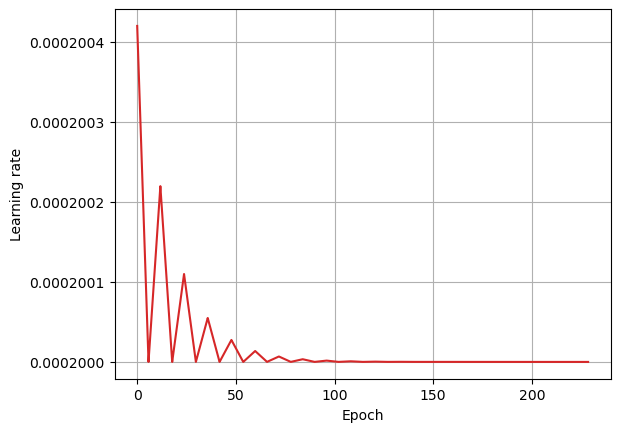

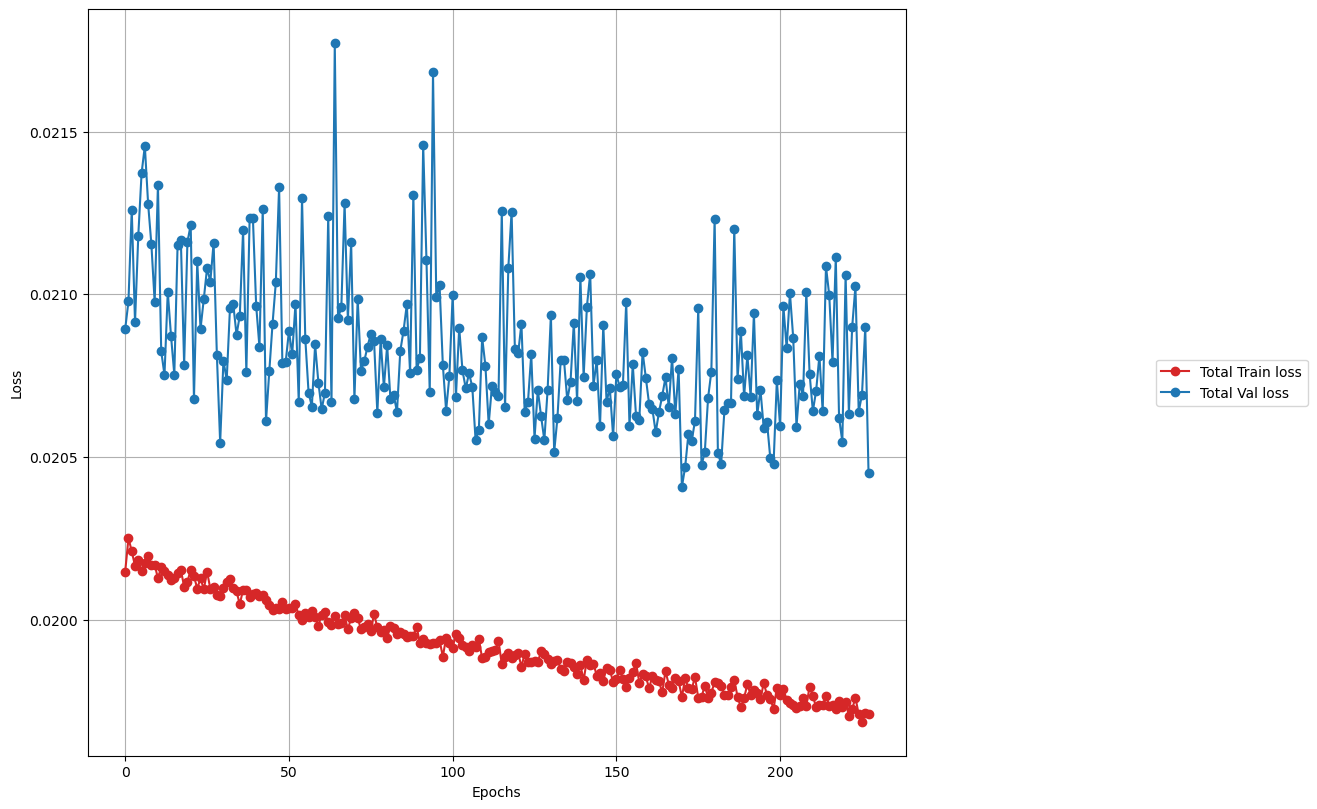

In [56]:
batches = np.linspace(0,len(metrics['lrs']),len(metrics['lrs'])+1)
epoch_list = batches/iterations_per_epoch

plt.plot(epoch_list[1:],metrics['lrs'], 'C3-')
plt.grid()
plt.ylabel("Learning rate")
plt.xlabel("Epoch")


losses_arr = np.array(metrics['losses'])
val_losses_arr = np.array(metrics['val_losses'])
losses_arr.shape
fig, ax = plt.subplots(1,sharex=True, figsize=(15, 8))
ax.plot(losses_arr[:,0], 'C3o-', label = "Total Train loss")
ax.plot(val_losses_arr[:,0], 'C0o-', label = "Total Val loss")
ax.set(ylabel='Loss')
ax.grid()
ax.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.tight_layout()
plt.xlabel("Epochs")
plt.show()

<Figure size 640x480 with 0 Axes>

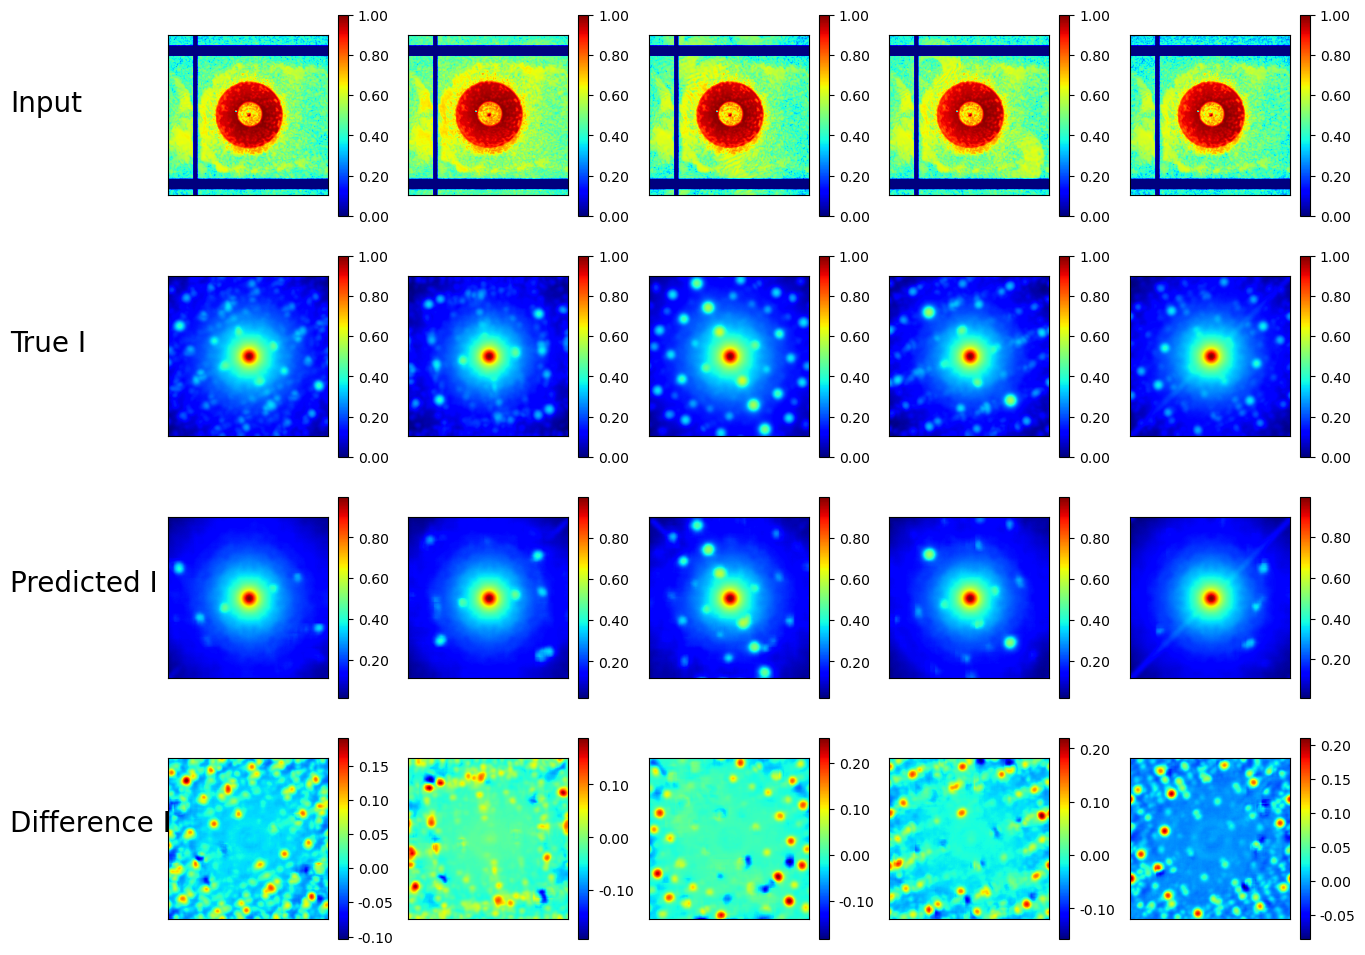

In [58]:
model.eval()
#model_new.eval() #imp when have dropout etc
results = []
for i, test in enumerate(testloader):
    tests = test[0].to(device)
    testsp = test[1].to(device)
    result = model(tests)
    for j in range(tests.shape[0]):
        results.append(result[j].detach().to("cpu").numpy())
        
results = np.array(results).squeeze()



h,w = H,W
ntest=results.shape[0]
plt.figure()
n = 5
f,ax=plt.subplots(4,n,figsize=(15, 12))
plt.gcf().text(0.02, 0.8, "Input", fontsize=20)
plt.gcf().text(0.02, 0.6, "True I", fontsize=20)
plt.gcf().text(0.02, 0.4, "Predicted I", fontsize=20)
plt.gcf().text(0.02, 0.2, "Difference I", fontsize=20)

for i in range(0,n):
    j=int(round(np.random.rand()*ntest))

    # display FT
    im=ax[0,i].imshow(X_test[j].reshape(h, w))#,norm=colors.LogNorm())
    plt.colorbar(im, ax=ax[0,i], format='%.2f')
    ax[0,i].get_xaxis().set_visible(False)
    ax[0,i].get_yaxis().set_visible(False)

    # display original intens
    im=ax[1,i].imshow(Y_I_test[j].reshape(h, w))#,norm=colors.LogNorm())
    plt.colorbar(im, ax=ax[1,i], format='%.2f')
    ax[1,i].get_xaxis().set_visible(False)
    ax[1,i].get_yaxis().set_visible(False)
    
    # display predicted intens
    im=ax[2,i].imshow(results[j].reshape(h, w))#,norm=colors.LogNorm())
    plt.colorbar(im, ax=ax[2,i], format='%.2f')
    ax[2,i].get_xaxis().set_visible(False)
    ax[2,i].get_yaxis().set_visible(False)

    #Difference in amplitude
    im=ax[3,i].imshow(Y_I_test[j].reshape(h, w)-results[j].reshape(h, w))#,norm=colors.LogNorm())
    plt.colorbar(im, ax=ax[3,i], format='%.2f')
    ax[3,i].get_xaxis().set_visible(False)
    ax[3,i].get_yaxis().set_visible(False)
plt.show()